In [69]:
import torch
import numpy as np
import matplotlib.pyplot as plt

states = torch.tensor([0, 1, 2])
Transition = torch.tensor([[0, 1/2, 1/2],
                           [1/2, 0, 1/2],
                           [1/2, 1/2, 0]])
obs = torch.tensor([0, 0, 2, 1, 1, 2])
Observation = torch.tensor([[1/2, 1/4, 1/3],
                            [1/4, 1/4, 1/3],
                            [1/4, 1/2, 1/3]])
Duration = torch.tensor([[1, 0, 0],
                         [0, 1, 0],
                         [0, 0, 1]])

tensor([[0.5000, 0.5000, 0.3333, 0.2500, 0.2500, 0.3333],
        [0.2500, 0.2500, 0.3333, 0.2500, 0.2500, 0.3333],
        [0.2500, 0.2500, 0.3333, 0.5000, 0.5000, 0.3333]], requires_grad=True)


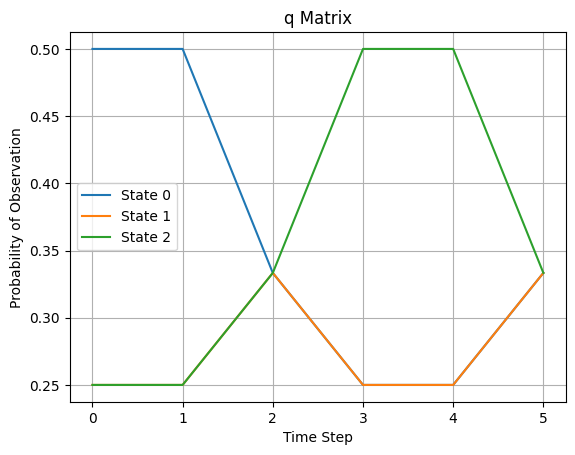

In [70]:
def q_matrix(obs, Observation):
    return Observation[:, obs].requires_grad_(True)

q = q_matrix(obs, Observation)
print(q)

# plot
time_steps = range(len(obs))
plt.figure()
for state in states:
    probs = [q[state][i].detach().numpy() for i in range(len(obs))]
    plt.plot(time_steps, probs, label=f"State {state}")

plt.xlabel('Time Step')
plt.ylabel('Probability of Observation')
plt.title('q Matrix')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
def matrix_mult_factor(log_alpha_row, Transition):
    alpha_row = torch.exp(log_alpha_row)
    product = alpha_row @ Transition
    factor = torch.sum(product)
    return torch.log(factor)

def matrix_mult_vec(log_alpha_row, Transition):
    result = torch.exp(log_alpha_row)@Transition
    if torch.sum(result) != 0:
        return torch.log(result / torch.sum(result))
    else:
        return torch.zeros_like(result)

tensor([[   nan,    nan,    nan,    nan,    nan, 0.0006],
        [   nan,    nan,    nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan,    nan,    nan]])
[[0.16666666 0.         0.        ]
 [0.         0.02083333 0.        ]
 [0.00347222 0.00694444 0.00694444]
 [0.00173611 0.         0.00347222]
 [0.00043403 0.00032552 0.00086806]
 [0.00019893 0.00021701 0.00043403]]


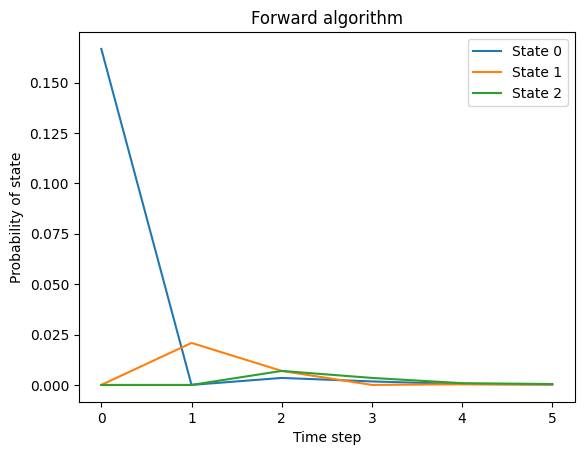

In [72]:
def forward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[0])
    log_alpha_list = []
    start = torch.tensor([1/3, 1/3, 1/3])

    # initialization
    for t in range(D):
        new_log_alpha = torch.log(start) + torch.log(Duration[:, t]) + torch.sum(torch.log(q[:, :t+1]), dim=1)
        for d in range(t):
            factor = torch.column_stack([matrix_mult_factor(log_alpha_list[t-d-1], Transition)]*N)
            vector = matrix_mult_vec(log_alpha_list[t-d-1], Transition)
            new_log_alpha = torch.logaddexp(new_log_alpha, factor + vector + torch.log(Duration[:, d]) + torch.sum(torch.log(q[:, t-d:t+1]), dim=1)).squeeze()
        log_alpha_list.append(new_log_alpha)
    
    # fill log_alpha[D:]
    for t in range(D, T):
        log_alpha_list.append(torch.full((N,), -float('inf')))
        new_log_alpha = log_alpha_list[t]
        for d in range(D):
            factor = torch.column_stack([matrix_mult_factor(log_alpha_list[t-d-1], Transition)]*N)
            vector = matrix_mult_vec(log_alpha_list[t-d-1], Transition)
            new_log_alpha = torch.logaddexp(new_log_alpha, factor + vector + torch.log(Duration[:, d]) + torch.sum(torch.log(q[:, t-d:t+1]), dim=1)).squeeze()
        log_alpha_list[t] = new_log_alpha 

    log_alpha = torch.exp(torch.stack(log_alpha_list))
    log_alpha_sum = torch.sum(log_alpha)
    log_alpha_sum.backward()
    print(q.grad)
    
    return log_alpha


fwd = forward(states, Transition, obs, q, Duration).detach().numpy()
print(fwd)

# plot
for state in states:
    probs = [fwd[t][state] for t in range(len(obs))]
    plt.plot(time_steps, probs, label =f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Forward algorithm')
plt.legend()
plt.show()

[[0.16666666 0.         0.        ]
 [0.         0.02083333 0.        ]
 [0.00347222 0.00694444 0.00694444]
 [0.00173611 0.         0.00347222]
 [0.00043403 0.00032552 0.00086806]
 [0.00019893 0.00021701 0.00043403]]


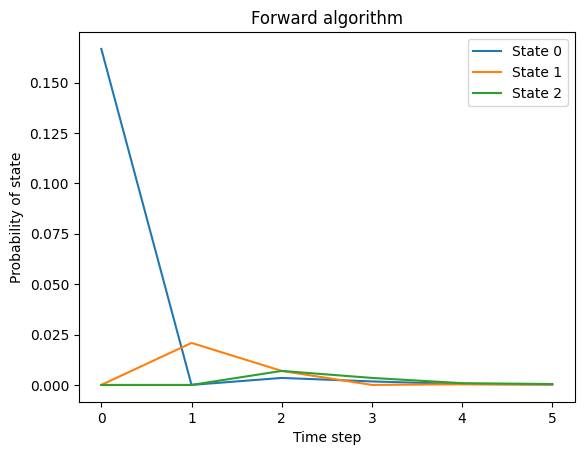

In [73]:
def forward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[0])
    log_alpha = torch.full((T, N), -float('inf'))
    start = torch.tensor([1/3, 1/3, 1/3])

    # initialization
    for t in range(D):
        log_alpha[t] = torch.log(start) + torch.log(Duration[:, t]) + torch.sum(torch.log(q[:, :t+1]), dim=1)
        for d in range(t):
            factor = torch.column_stack([matrix_mult_factor(log_alpha[t-d-1], Transition)]*N)
            vector = matrix_mult_vec(log_alpha[t-d-1], Transition)
            log_alpha[t] = torch.logaddexp(log_alpha[t], factor + vector + torch.log(Duration[:, d]) + torch.sum(torch.log(q[:, t-d:t+1]), dim=1))
    
    # fill log_alpha[D:]
    for t in range(D, T):
        for d in range(D):
            factor = torch.column_stack([matrix_mult_factor(log_alpha[t-d-1], Transition)]*N)
            vector = matrix_mult_vec(log_alpha[t-d-1], Transition)
            log_alpha[t] = torch.logaddexp(log_alpha[t], factor + vector + torch.log(Duration[:, d]) + torch.sum(torch.log(q[:, t-d:t+1]), dim=1))
    
    return torch.exp(log_alpha)

fwd = forward(states, Transition, obs, q, Duration).detach().numpy()
print(fwd)

# plot
for state in states:
    probs = [fwd[t][state] for t in range(len(obs))]
    plt.plot(time_steps, probs, label =f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Forward algorithm')
plt.legend()
plt.show()

tensor(3.5595, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan]])
[[0.00282118 0.00260417 0.00368924]
 [0.00694444 0.01475694 0.0078125 ]
 [0.046875   0.046875   0.01041667]
 [0.04166666 0.         0.04166666]
 [0.         0.16666666 0.16666666]
 [1.         1.         1.        ]]


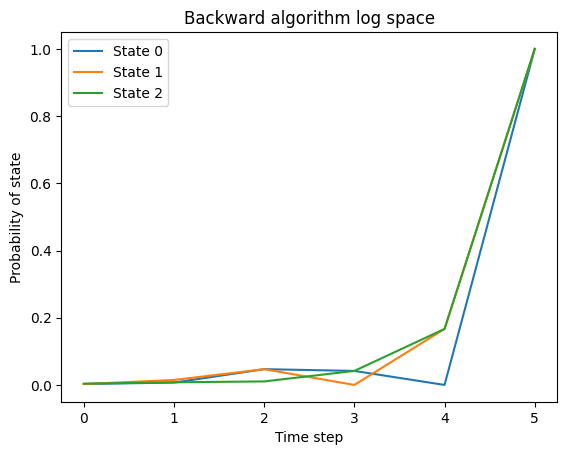

In [74]:
def backward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[0])
    log_beta = torch.full((T, N), -float('inf'))

    # initialization, log_beta[-1]
    log_beta_new = log_beta.clone()
    log_beta_new[-1] = torch.zeros(N)
    log_beta = log_beta_new
    
    # fill log_beta[:-1]
    for t in range(T - 2, -1, -1):
        for d in range(D):
            if t + d <= T - 2:
                log_beta_new = log_beta.clone()
                log_beta_new[t] = torch.logaddexp(log_beta[t], torch.logsumexp(torch.row_stack([log_beta[t+d+1]]*N) + torch.log(Transition) + torch.log(torch.row_stack([Duration[:, d]]*N)) + torch.sum(torch.log(q[:, t + 1:t + d + 2]), axis=1), axis=1))
                log_beta = log_beta_new

    log_beta = torch.exp(log_beta)
    log_beta_sum = torch.sum(log_beta)
    log_beta_sum.backward()
    print(log_beta_sum)
    print(q.grad)

    return log_beta


bwd = backward(states, Transition, obs, q, Duration).detach().numpy()
print(bwd)

# plot
for state in states:
    probs = [bwd[t][state] for t in range(len(obs))]
    plt.plot(range(len(obs)), probs, label=f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Backward algorithm log space')
plt.legend()
plt.show()

[[0.00282118 0.00260417 0.00368924]
 [0.00694444 0.01475694 0.0078125 ]
 [0.046875   0.046875   0.01041667]
 [0.04166666 0.         0.04166666]
 [0.         0.16666666 0.16666666]
 [1.         1.         1.        ]]


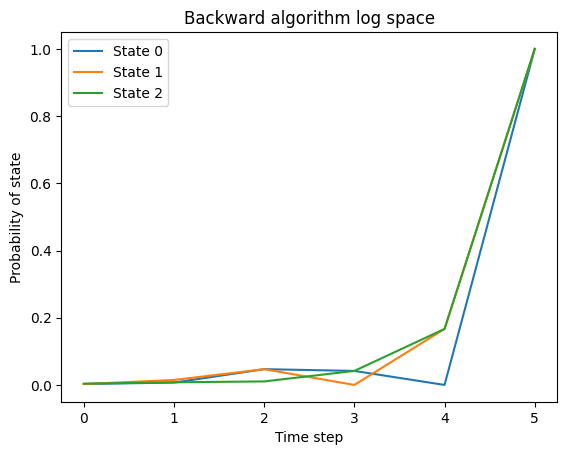

In [75]:
def backward(states, Transition, obs, q, Duration):
    T = len(obs)
    N = len(states)
    D = len(Duration[0])
    log_beta = torch.full((T, N), -float('inf'))

    # initialization, log_beta[-1]
    log_beta[-1] = torch.zeros(N)
    
    # fill log_beta[:-1]
    for t in range(T - 2, -1, -1):
        for d in range(D):
            if t + d <= T - 2:
                log_beta[t] = torch.logaddexp(log_beta[t], torch.logsumexp(torch.row_stack([log_beta[t+d+1]]*N) + torch.log(Transition) + torch.log(torch.row_stack([Duration[:, d]]*N)) + torch.sum(torch.log(q[:, t + 1:t + d + 2]), axis=1), axis=1))

    return torch.exp(log_beta)

bwd = backward(states, Transition, obs, q, Duration).detach().numpy()
print(bwd)

# plot
for state in states:
    probs = [bwd[t][state] for t in range(len(obs))]
    plt.plot(range(len(obs)), probs, label=f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Backward algorithm log space')
plt.legend()
plt.show()

[[0.5531914  0.         0.        ]
 [0.         0.36170202 0.        ]
 [0.19148932 0.38297865 0.08510637]
 [0.08510637 0.         0.17021273]
 [0.         0.06382974 0.17021273]
 [0.23404261 0.2553192  0.5106382 ]]


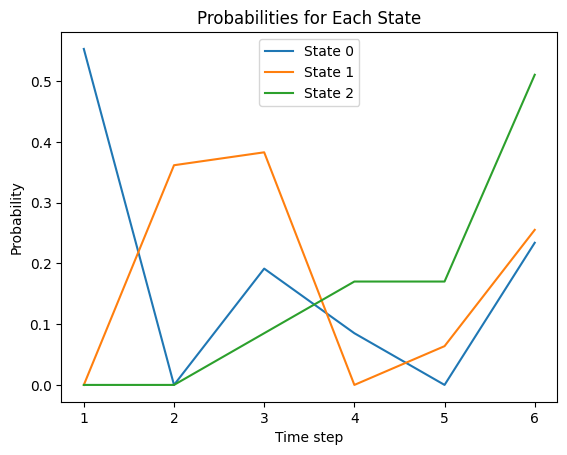

In [76]:
def fb_alg(states, Transition, obs, q, Duration):
    T = len(obs)
    alpha = forward(states, Transition, obs, q, Duration).detach().numpy()
    beta = backward(states, Transition, obs, q, Duration).detach().numpy()
    fb_probs = alpha * beta
    
    # normalize
    fb_sum = np.sum(alpha[T-1])
    fb_probs /= fb_sum if fb_sum != 0 else 1
    
    return np.array(fb_probs)

fb_probs = fb_alg(states, Transition, obs, q, Duration)
print(fb_probs)

# plot
for state in states:
    probs = [fb_probs[t][state] for t in range(len(fb_probs))]
    plt.plot(range(1, len(fb_probs) + 1), probs, label=f'State {state}')

plt.xlabel('Time step')
plt.ylabel('Probability')
plt.title('Probabilities for Each State')
plt.legend()
plt.show()